# Tutorial 2: Transfer learning from MNIST to USPS!

First, we import the necessary modules

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import sys
from dataset.usps import USPS
import numpy as np
import matplotlib.pyplot as plt

Set up argument parser for command line arguments

In [2]:
# Parameters
epochs = 10 # number of epochs to train (default: 10)
fine_tuning_on_mnist = 'last-layer' # 'last-layer' / 'all-layers'
mnist_pretrained_model = 'mnist_models/mnist.pth' # path to MNIST pretrained model


Set up Visdom (for visualizing loss curve)

In [3]:


def plot_loss_curve(nepochs, test_losses, accuracies):
    plt.title('USPS loss curve, fine tune: ' + fine_tuning_on_mnist)
    plt.xticks(np.arange(0, nepochs, 1))
    plt.plot(range(nepochs), test_losses, 'r--', label='Loss')
    plt.plot(range(nepochs), accuracies, 'b', label='Accuracy')
    plt.legend()



Define model structure

In [4]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Set up model and optimizer. Decide which fine-tuning method to use
(no tuning / tuning only last layer / tuning all layers) for transfer
learning from MNIST model.

In [5]:
model = MNISTNet()

layers_to_tune = model

if fine_tuning_on_mnist in ['last-layer', 'all-layers']:
    pretrained_model_path = mnist_pretrained_model
    model.load_state_dict(torch.load(pretrained_model_path))

    if fine_tuning_on_mnist == 'last-layer':
        # Replace the last layer with a new uninitiated one, and only tune the parameters for this layer
        model.fc2 = nn.Linear(50, 10)
        layers_to_tune = model.fc2

optimizer = optim.SGD(layers_to_tune.parameters(), lr=0.01, momentum=0.5)

Load train and test data

In [6]:
pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                  mean=(0.5, 0.5, 0.5),
                                  std=(0.5, 0.5, 0.5))])

usps_dataset_train = USPS(root="data",
                    train=True,
                    transform=pre_process,
                    download=True)

train_loader = torch.utils.data.DataLoader(
                    dataset=usps_dataset_train,
                    batch_size=64,
                    shuffle=True)

usps_dataset_test = USPS(root="data",
                    train=False,
                    transform=pre_process,
                    download=True)

test_loader = torch.utils.data.DataLoader(
                    dataset=usps_dataset_test,
                    batch_size=1000,
                    shuffle=True)

Method for training the model

In [7]:
def train(epoch):
    model.train()
    num_batches = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.reshape(-1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), float(loss)))
        num_batches += 1
    torch.save(model.state_dict(), 'checkpoints/usps_%s.pth' % (epoch, ))

Method for testing the model

In [8]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        target = target.reshape(-1)
        with torch.no_grad():
            output = model(data)
            test_loss += float(F.nll_loss(output, target, size_average=False)) # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += int(pred.eq(target.data.view_as(pred)).cpu().long().sum())

    test_loss /= len(test_loader.dataset)
    accuracy = correct * 1.0 / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))
    
    return test_loss, accuracy

Train and test the model for a few epochs

Train Epoch: 1 [0/7438 (0%)]	Loss: 6.503110
Train Epoch: 1 [640/7438 (9%)]	Loss: 2.629877
Train Epoch: 1 [1280/7438 (17%)]	Loss: 2.074764
Train Epoch: 1 [1920/7438 (26%)]	Loss: 1.712783
Train Epoch: 1 [2560/7438 (34%)]	Loss: 1.688060
Train Epoch: 1 [3200/7438 (43%)]	Loss: 1.178249
Train Epoch: 1 [3840/7438 (51%)]	Loss: 1.222356
Train Epoch: 1 [4480/7438 (60%)]	Loss: 1.377424
Train Epoch: 1 [5120/7438 (68%)]	Loss: 1.552507
Train Epoch: 1 [5760/7438 (77%)]	Loss: 1.503023
Train Epoch: 1 [6400/7438 (85%)]	Loss: 1.269178
Train Epoch: 1 [7040/7438 (94%)]	Loss: 1.259289

Test set: Average loss: 0.7729, Accuracy: 1337/1860 (72%)

Train Epoch: 2 [0/7438 (0%)]	Loss: 1.408105
Train Epoch: 2 [640/7438 (9%)]	Loss: 1.299244
Train Epoch: 2 [1280/7438 (17%)]	Loss: 1.467557
Train Epoch: 2 [1920/7438 (26%)]	Loss: 1.590887
Train Epoch: 2 [2560/7438 (34%)]	Loss: 1.560398
Train Epoch: 2 [3200/7438 (43%)]	Loss: 1.524149
Train Epoch: 2 [3840/7438 (51%)]	Loss: 1.327941
Train Epoch: 2 [4480/7438 (60%)]	Loss: 1

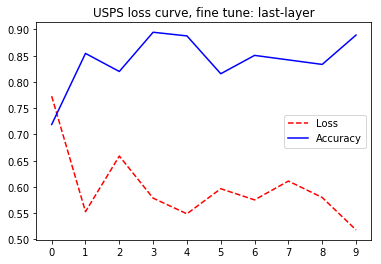

In [9]:
test_losses = []
accuracies = []
for epoch in range(1, epochs + 1):
    train(epoch)
    test_loss, accuracy = test(epoch)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    
plot_loss_curve(epoch, test_losses, accuracies)

To run this example, do the following (also open http://localhost:8097/ to visualize the loss curve):